# Demo - Virtual Inertia Scheduling

ANDES case: ``ieee39_vis.xlsx``

Source data: ``ieee39_vis_1_out.csv``, ``ieee39_vis_4_out.csv``.

Output data: Source data are cut to the first two minutes as ``ieee39_vis_1_out_short.csv``, ``ieee39_vis_4_out_short.csv``.

Then the emulated measured bus data ``BusFreq`` output are added in the file ``ieee39_vis_1_out_short_emu.csv``, ``ieee39_vis_4_out_short_emu.csv``.

Three scenarios are considered in this demo:
1. ``ieee39_vis_1_out_short.csv``: No VIS.
2. ``ieee39_vis_4_out_short.csv``: With VIS.

ANDES case file ``ieee39_vis.xlsx`` and output file ``ieee39_vis_4_out_short_emu.csv`` can be used in AGVis to visualize the results.

In [5]:
import numpy as np
import pandas as pd
import scipy.signal as sig

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

import os

import andes

In [6]:
andes.__version__

'1.8.7.post5+gb9281204'

In [7]:
cwd = os.getcwd()

In [8]:
vis1_path = os.path.join(cwd, '../data/source/ieee39_vis_1_out.csv')
vis4_path = os.path.join(cwd, '../data/source/ieee39_vis_4_out.csv')

vis1_read = pd.read_csv(vis1_path)
vis4_read = pd.read_csv(vis4_path)

In [18]:
visout_path = os.path.join(cwd, '../data/output/ieee39_vis_out.csv')
visout = pd.read_csv(visout_path)

In [9]:
vis1 = vis1_read[vis1_read['Time [s]'] <= 120]
vis4 = vis4_read[vis4_read['Time [s]'] <= 120]

In [24]:
ss = andes.load(os.path.join(cwd, '../data/case/ieee39_vis.xlsx'))

In [12]:
cols = [string for string in vis1.columns if "Wf_y" in string]
cols = ['Time [s]'] + cols

vis1c = vis1.copy()
vis4c = vis4.copy()

# Scale ROCOF to nominal values
vis1c[cols[1:]] = vis1c[cols[1:]].apply(lambda x: x*ss.config.freq)
vis4c[cols[1:]] = vis4c[cols[1:]].apply(lambda x: x*ss.config.freq)

In [13]:
vis1.to_csv(os.path.join(cwd, '../data/output/ieee39_vis1_out_short.csv'), index=False)
vis4.to_csv(os.path.join(cwd, '../data/output/ieee39_vis4_out_short.csv'), index=False)

In [14]:
%matplotlib inline

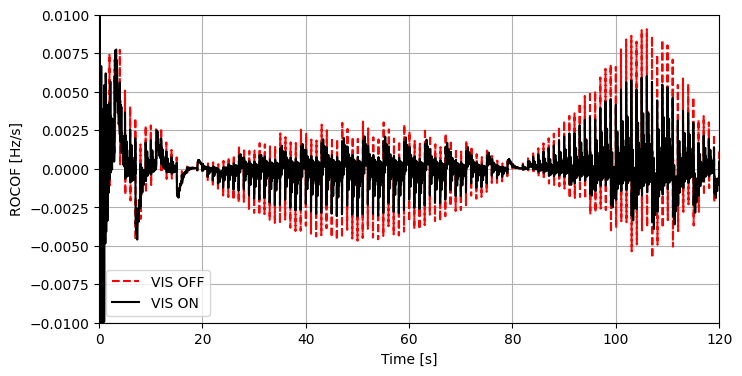

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))

col = cols[7]

vis1c.plot(x='Time [s]', y=col,
           style='--', color='red',
           label='VIS OFF',
           legend=True,
           ax=ax, fig=fig)

vis4c.plot(x='Time [s]', y=col,
           style='-', color='black',
           label='VIS ON',
           legend=True,
           ax=ax, fig=fig)

ax.set_xlim([0, 120])
ax.set_ylim([-0.01, 0.01])
ax.set_ylabel('ROCOF [Hz/s]')
ax.grid()

plt.show()

In [21]:
vis4_out = pd.DataFrame(data=np.zeros((vis4.shape[0], visout.shape[1])), columns=visout.columns.tolist())
vis4_out['Time [s]'] = vis4['Time [s]']

t = vis4_out['Time [s]'].values

In [26]:
# Create the transfer function object
Lag = sig.lti([0, 1], [0.2, 1])
Washout = sig.lti([1 / 2 / np.pi / ss.config.freq, 0], [0.02, 1])

for n in range(1, 40):
    a = vis4[f'a Bus {n}'].values
    # Simulate the response to the input signal
    t, y, _ = sig.lsim2(Lag, a, t)
    t, freq, _ = sig.lsim2(Washout, y, t)
    vis4_out[f'f BusFreq {n}'] = freq + 1
    vis4_out[f'WO_y BusFreq {n}'] = freq

/Users/jinningwang/Documents/work/mambaforge/envs/demo/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1746: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


In [27]:
vis4_out_path = os.path.join(cwd, '../data/output/ieee39_vis4_out_short_emu.csv')
vis4_out.to_csv(vis4_out_path, index=False)